In [1]:
#Set up the environment
library(reshape2)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
#Load in the lineage-corrected ancestry-associated p-value data frame
setwd("../data")
lineage.corrected.pvals = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

#Load in the expression data
setwd("../data")
ccle.expression.22q1 = read.table("22q1_expression.csv", sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1)) %>%
rename("sample" = 1)

In [4]:
#Get a vector that has all of the ancestry-associated gene names
ancestry.associated.genes = lineage.corrected.pvals %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene)

In [5]:
#Load in a list of common-essential genes
setwd("../data")
common.essentials = read.table("common_essentials.csv", sep = ",", header = T) %>%
setNames(word(names(.), 1)) %>%
pull(gene) %>%
word(., 1)

In [6]:
#Compute the median expression of all genes
median.expression.all.genes = ccle.expression.22q1 %>%
select(-sample) %>%
apply(2, median)

#Compute the median expression for all of the ancestry associated genes
median.expression.ancestry.associated = ccle.expression.22q1 %>%
melt(id = "sample") %>%
filter(variable %in% ancestry.associated.genes) %>%
group_by(variable) %>%
summarise("median_value" = median(value)) %>%
pull(median_value)

#Compute the median expression for all of the common essential genes
median.expression.common.essential = ccle.expression.22q1 %>%
melt(id = "sample") %>%
filter(variable %in% common.essentials) %>%
group_by(variable) %>%
summarise("median_value" = median(value)) %>%
pull(median_value)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


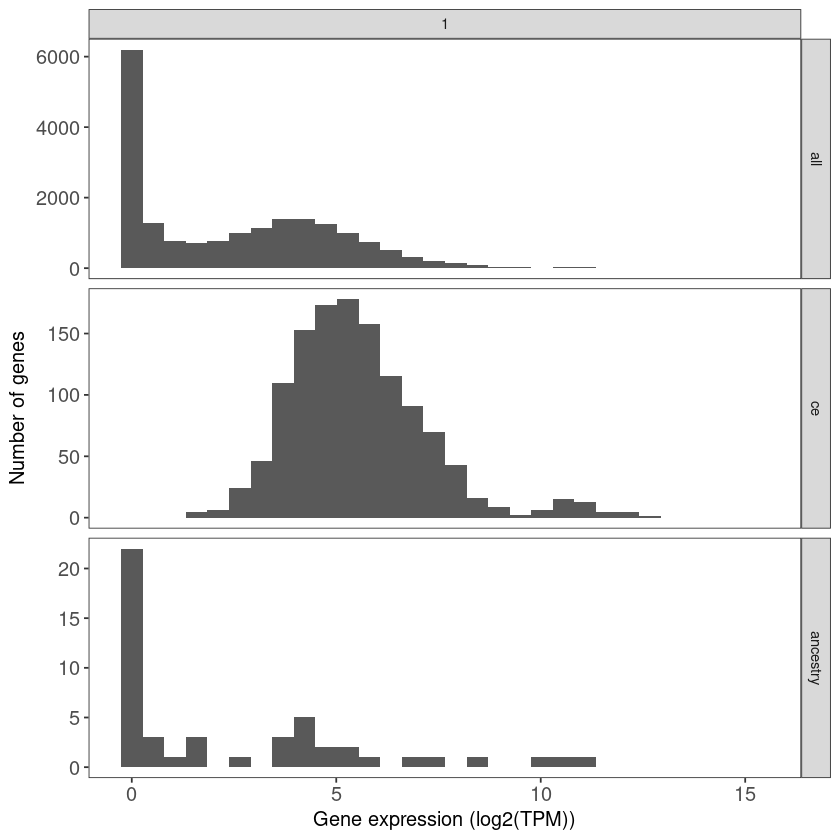

In [7]:
#Compile a data frame that has all of these data
class.vector = c(rep("all", length(median.expression.all.genes)), rep("ancestry", length(median.expression.ancestry.associated)), rep("ce", length(median.expression.common.essential)))
expression.vector = c(median.expression.all.genes, median.expression.ancestry.associated, median.expression.common.essential)

#Plot the plot
cbind(class.vector, expression.vector) %>%
data.frame() %>%
rename("gene_class" = 1, "expression" = 2) %>%
mutate(expression = as.numeric(expression)) %>%
mutate(gene_class = factor(gene_class, levels = c("all", "ce", "ancestry"))) %>%
ggplot(aes(x = expression)) +
geom_histogram(position = "identity") +
facet_grid(gene_class ~ 1, scales = "free") +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Number of genes") +
xlab("Gene expression (log2(TPM))")


#Export it to the google bucket
setwd('../output')
ggsave("figure_2e.pdf", width = 2, height = 4)


In [8]:
#Export the dataset for making figure 2e

#Compile a data frame that has all of these data
class.vector = c(rep("all", length(median.expression.all.genes)), rep("ancestry", length(median.expression.ancestry.associated)), rep("ce", length(median.expression.common.essential)))
expression.vector = c(median.expression.all.genes, median.expression.ancestry.associated, median.expression.common.essential)

#Plot the plot
df_for_plotting = cbind(class.vector, expression.vector) %>%
data.frame() %>%
rename("gene_class" = 1, "expression" = 2) %>%
mutate(expression = as.numeric(expression)) %>%
mutate(gene_class = factor(gene_class, levels = c("all", "ce", "ancestry")))


#Write it out
setwd("../output")
write.table(df_for_plotting, "figure_2e_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)
